## CNN 2 - Skin Disease Detection : Oussama FIKRI, Brahim GOUALI et Hamza BOUKHRISSE

# Importation des différentes bibliothèques

In [1]:
# importer les bibliothèques
import os
import time
import shutil
import itertools

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import categorical_crossentropy

# Ignorer les alertes
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


### Chargement des données

In [2]:
data_dir = '/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv'
data = pd.read_csv(data_dir)
data.head()


,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


# **Data Preprocessing**

### Séparation des valeurs indépendantes et de la valeur cible

In [3]:
Label = data["label"]
Data = data.drop(columns=["label"]) 

### Utilisation de RandomOverSampler pour fixer les datasets inbalancées

In [4]:
from imblearn.over_sampling import RandomOverSampler 

oversample = RandomOverSampler()
Data, Label  = oversample.fit_resample(Data, Label)
Data = np.array(Data).reshape(-1, 28, 28, 3)
print('Shape of Data :', Data.shape)

Shape of Data : (46935, 28, 28, 3)


In [5]:
Label = np.array(Label)
Label

array([2, 2, 2, ..., 6, 6, 6])

### Conversion des labels en format texte

In [6]:
# Chaque classe sera assignée à un nombre compris entre 0 et 6.

classes = {4: ('nv', ' melanocytic nevi'),
           6: ('mel', 'melanoma'),
           2 :('bkl', 'benign keratosis-like lesions'), 
           1:('bcc' , ' basal cell carcinoma'),
           5: ('vasc', ' pyogenic granulomas and hemorrhage'),
           0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
           3: ('df', 'dermatofibroma')}

### Splitting entrainement et test

In [7]:
from sklearn.model_selection import train_test_split

X_train , X_test , y_train , y_test = train_test_split(Data , Label , test_size = 0.25 , random_state = 49)

In [8]:
print(f'X_train shape: {X_train.shape}\nX_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}\ny_test shape: {y_test.shape}')

X_train shape: (35201, 28, 28, 3)
X_test shape: (11734, 28, 28, 3)
y_train shape: (35201,)
y_test shape: (11734,)


### Conversion des labels en format catégorique

In [9]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

### Génération d'images

In [10]:
# Crée un générateur de données pour les images d'entraînement avec augmentation de données
datagen = ImageDataGenerator(rescale=(1./255)
                             ,rotation_range=10
                             ,zoom_range = 0.1
                             ,width_shift_range=0.1
                             ,height_shift_range=0.1)

# Crée un générateur de données pour les images de test avec mise à l'échelle
testgen = ImageDataGenerator(rescale=(1./255))

In [11]:
from keras.callbacks import ReduceLROnPlateau

# Crée un objet ReduceLROnPlateau qui ajuste le taux d'apprentissage
# lorsque la performance du modèle sur la validation stagne
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',  # La métrique à surveiller
    patience=2,  # Nombre d'époques sans amélioration avant de réduire le taux d'apprentissage
    verbose=1,  # Affiche des messages lors de la réduction du taux d'apprentissage
    factor=0.5,  # Le facteur de réduction du taux d'apprentissage (nouveau_lr = lr * factor)
    min_lr=0.00001  # Valeur minimale du taux d'apprentissage
)

# Structure du modèle

In [12]:
import keras

model = keras.models.Sequential()

# Création du modèle
model.add(keras.layers.Input(shape=[28, 28, 3]))  # Couche d'entrée prenant des images de taille 28x28 avec 3 canaux de couleur
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
# Couche de convolution avec 32 filtres de taille 3x3, activation ReLU, padding pour garder la même taille de sortie, initialisation des poids avec he_normal
model.add(keras.layers.MaxPooling2D())  # Couche de pooling pour réduire la taille spatiale des caractéristiques
model.add(keras.layers.BatchNormalization())  # Couche de normalisation par lots pour normaliser les activations

model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())

model.add(keras.layers.Flatten())  # Conversion de la sortie des couches précédentes en un vecteur plat

model.add(keras.layers.Dropout(rate=0.2))  # Couche de régularisation dropout pour lutter contre le surapprentissage
model.add(keras.layers.Dense(units=256, activation='relu', kernel_initializer='he_normal'))  # Couche dense avec 256 neurones, activation ReLU, initialisation des poids avec he_normal
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(units=64, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(units=32, activation='relu', kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.L1L2()))
# Couche dense avec 32 neurones, activation ReLU, initialisation des poids avec he_normal et régularisation L1L2
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(units=7, activation='softmax', kernel_initializer='glorot_uniform', name='classifier'))
# Couche de sortie avec 7 neurones correspondant aux classes d'objets, activation softmax, initialisation des poids avec glorot_uniform

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
# Compilation du modèle avec l'optimiseur Adamax, taux d'apprentissage de 0.001, fonction de perte categorical_crossentropy et métrique d'évaluation accuracy

model.summary()  # Affichage du résumé du modèle

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 64)          2

### Entrainement du modèle

In [13]:
history = model.fit(X_train,  # Données d'entraînement
                    y_train,  # Étiquettes correspondantes des données d'entraînement
                    epochs=25,  # Nombre d'époques d'entraînement
                    batch_size=128,  # Taille des mini-lots utilisés pour l'entraînement
                    validation_data=(X_test, y_test),  # Données de validation utilisées pour évaluer le modèle à la fin de chaque époque
                    callbacks=[learning_rate_reduction])  # Liste des rappels (callbacks) à utiliser pendant l'entraînement

Epoch 1/25
276/276 [==============================] - 12s 15ms/step - loss: 1.1546 - accuracy: 0.5893 - val_loss: 0.9329 - val_accuracy: 0.6550
Epoch 2/25
276/276 [==============================] - 3s 11ms/step - loss: 0.4960 - accuracy: 0.8332 - val_loss: 0.3582 - val_accuracy: 0.8827
Epoch 3/25
276/276 [==============================] - 3s 11ms/step - loss: 0.3007 - accuracy: 0.8987 - val_loss: 0.2867 - val_accuracy: 0.8974
Epoch 4/25
276/276 [==============================] - 3s 11ms/step - loss: 0.2027 - accuracy: 0.9313 - val_loss: 0.1570 - val_accuracy: 0.9476
Epoch 5/25
276/276 [==============================] - 3s 11ms/step - loss: 0.1438 - accuracy: 0.9518 - val_loss: 0.1723 - val_accuracy: 0.9399
Epoch 6/25
276/276 [==============================] - 3s 11ms/step - loss: 0.1081 - accuracy: 0.9642 - val_loss: 0.1906 - val_accuracy: 0.9307

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/25
276/276 [==============================] - 3s 11m

### L'historique de l'entrainement

In [14]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize=(20, 8))
    plt.style.use('default')  # Utilisation du style par défaut, qui a un fond blanc

    Epochs = [i + 1 for i in range(len(tr_acc))]
    loss_label = f'best epoch = {str(index_loss + 1)}'
    acc_label = f'best epoch = {str(index_acc + 1)}'
    
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'm', label='Training loss')  # Couleur magenta pour la courbe de perte d'entraînement
    plt.plot(Epochs, val_loss, 'c', label='Validation loss')  # Couleur cyan pour la courbe de perte de validation
    plt.scatter(index_loss + 1, val_lowest, s=150, c='r', label=loss_label)  # Point rouge pour le minimum de perte de validation
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'm', label='Training Accuracy')  # Couleur magenta pour la courbe d'exactitude d'entraînement
    plt.plot(Epochs, val_acc, 'c', label='Validation Accuracy')  # Couleur cyan pour la courbe d'exactitude de validation
    plt.scatter(index_acc + 1, acc_highest, s=150, c='r', label=acc_label)  # Point rouge pour le maximum d'exactitude de validation
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

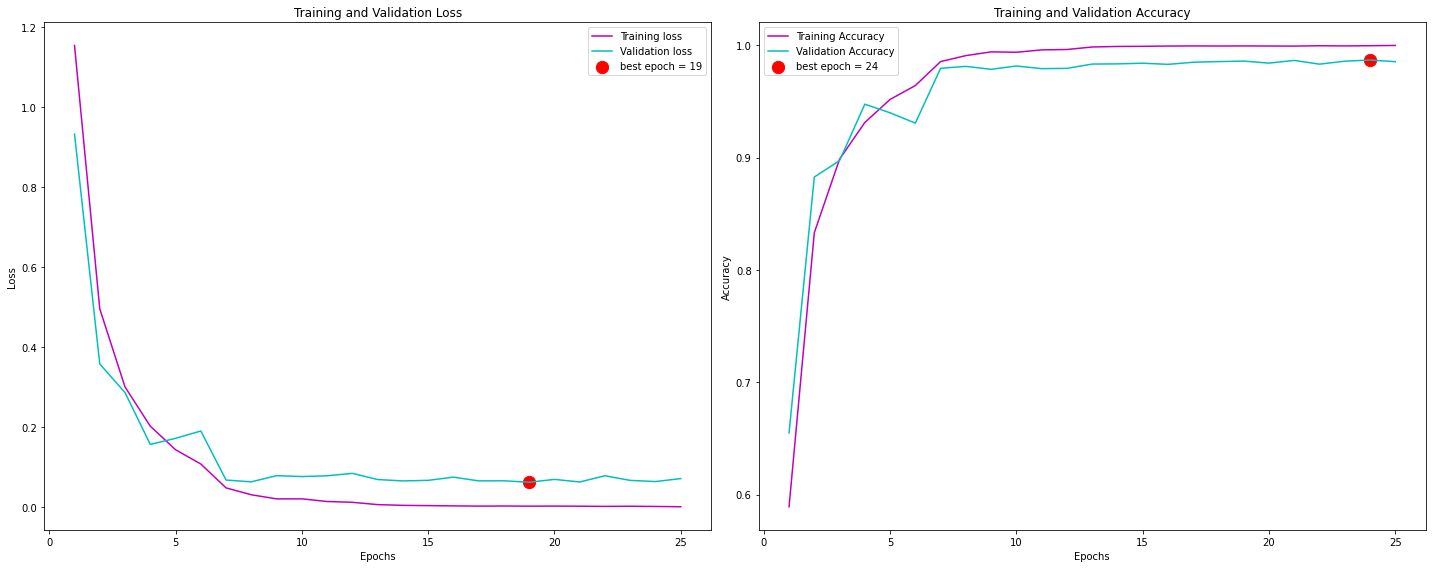

In [15]:
plot_training(history)

# Evaluation du modèle

In [16]:
train_score = model.evaluate(X_train, y_train, verbose= 1)
test_score = model.evaluate(X_test, y_test, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

367/367 [==============================] - 1s 4ms/step - loss: 0.0716 - accuracy: 0.9854
Train Loss:  0.00011690468818414956
Train Accuracy:  1.0
--------------------
Test Loss:  0.0716361477971077
Test Accuracy:  0.9854269623756409


### Matrice de Confusion

In [21]:
y_true = np.array(y_test)  # Convertit les étiquettes de test en un tableau NumPy
y_pred = model.predict(X_test)  # Effectue des prédictions sur les données de test

y_pred = np.argmax(y_pred, axis=1)  # Convertit les prédictions en utilisant l'indice de la classe prédite avec la plus grande probabilité
y_true = np.argmax(y_true, axis=1)  # Convertit les étiquettes réelles en utilisant l'indice de la classe vraie

classes_labels = []
for key in classes.keys():
    classes_labels.append(key)  # Crée une liste des libellés de classe à partir des clés du dictionnaire "classes"

print(classes_labels)  

[4, 6, 2, 1, 5, 0, 3]


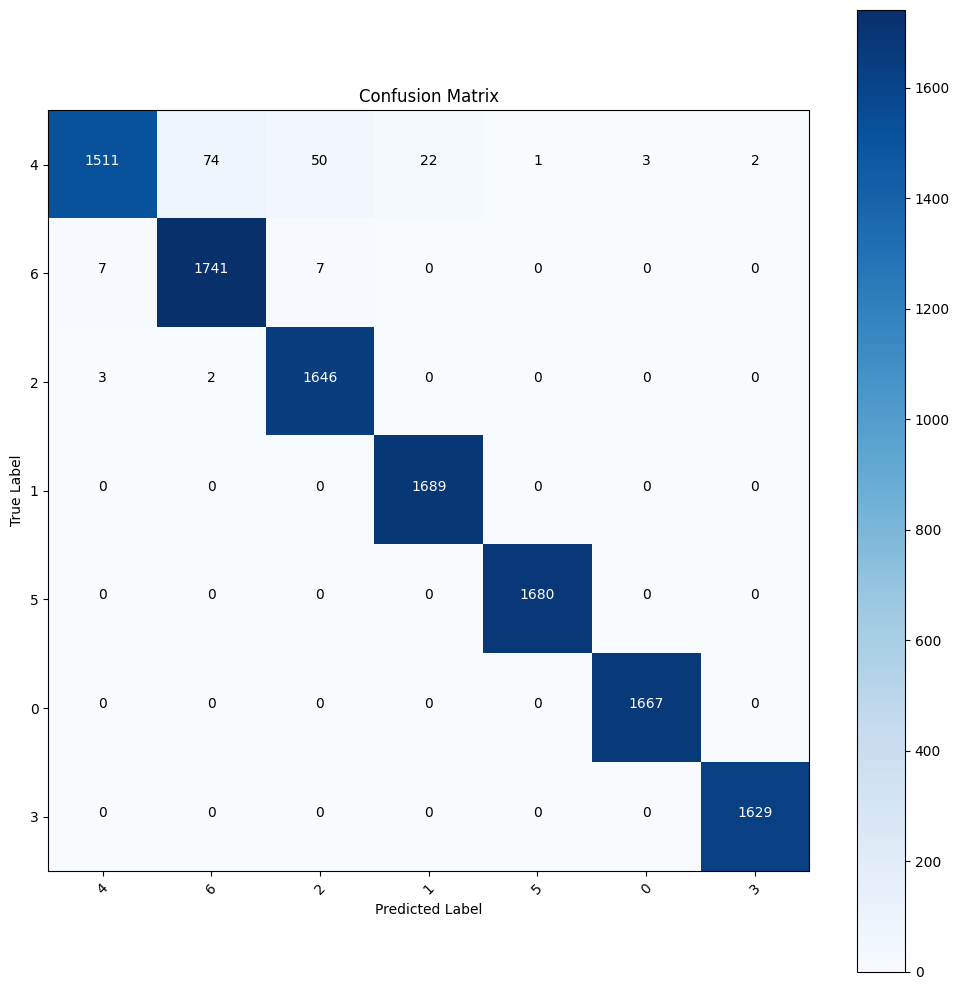

In [22]:
cm = confusion_matrix(y_true, y_pred, labels=classes_labels)  # Calcule la matrice de confusion en utilisant les étiquettes réelles et les prédictions

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)  # Affiche la matrice de confusion en utilisant une colormap bleue
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)  # Définit les libellés des axes x avec les noms des classes et les fait pivoter de 45 degrés
plt.yticks(tick_marks, classes)  # Définit les libellés des axes y avec les noms des classes

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')  # Ajoute les valeurs de la matrice de confusion comme texte dans les cellules correspondantes

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()  

### Sauvegarder le modèle

In [20]:
#Sauvegarder le modèle
model.save('CNN2.h5')